## Train model for geometric shapes
**Function        : Train model in pytorch for MNIST **<br>
**Author          : Team DIANNA **<br>
**Contributor     : **<br>
**First Built     : 2021.06.06 **<br>
**Last Update     : 2021.06.06 **<br>
**Library         : os, numpy, matplotlib, torch, tensorflow, wandb **<br>
**Description     : In this notebook we train models in pytorch for geometric shapes. The trained models will be used to explore the XAI methods later.**<br>
**Return Values   : pytorch models and training status (.pt) / training report from weights & biases**<br>

In [1]:
%matplotlib inline
import os
import time as tt
import numpy as np
from mlxtend.data import loadlocal_mnist
# DL framework
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
#import torchvision
# for plotting
import matplotlib.pyplot as plt
# report and monitoring with Weights & Biases
import wandb

In [2]:
#################################################################################
#########                     path to the dataset                        ########
#################################################################################
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/mnist'
# please specify output path
output_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/train_models/mnist'

In [4]:
#################################################################################
#########                 extract MNIST dataset locally                  ########
#################################################################################
# load MNIST from local using mlxtend (without using any ML framework eg. torch, tensorflow)
# training set
train_X, train_y = loadlocal_mnist(images_path= os.path.join(datapath,'train-images-idx3-ubyte'), 
                                   labels_path=os.path.join(datapath,'train-labels-idx1-ubyte'))
# testing set
test_X, test_y = loadlocal_mnist(images_path= os.path.join(datapath,'t10k-images-idx3-ubyte'), 
                                 labels_path=os.path.join(datapath,'t10k-labels-idx1-ubyte'))

# dimensions of data
print("dimensions of mnist:")
print("dimensions or training set", train_X.shape)
print("dimensions or training set label", train_y.shape)
print("dimensions or testing set", test_X.shape)
print("dimensions or testing set label", test_y.shape)
# statistics of training set
print("statistics of training set:")
print("Digits:  0 1 2 3 4 5 6 7 8 9")
print("labels: {}".format(np.unique(train_y)))
print("Class distribution: {}".format(np.bincount(train_y)))

dimensions of mnist:
dimensions or training set (60000, 784)
dimensions or training set label (60000,)
dimensions or testing set (10000, 784)
dimensions or testing set label (10000,)
statistics of training set:
Digits:  0 1 2 3 4 5 6 7 8 9
labels: [0 1 2 3 4 5 6 7 8 9]
Class distribution: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [6]:
#################################################################################
#########                 extract subset of MNIST dataset                ########
#################################################################################
# extract subset of MNIST
# get all the images labelled "0" and "1" (binary filtering)
label_a = 0
label_b = 1
train_X_binary = train_X[(train_y == label_a) | (train_y == label_b),:]
train_y_binary = train_y[(train_y == label_a) | (train_y == label_b)]
test_X_binary = test_X[(test_y == label_a) | (test_y == label_b),:]
test_y_binary = test_y[(test_y == label_a) | (test_y == label_b)]
# check the results
print("training set shape after filtering", train_X_binary.shape)
print("training set label shape after filtering", train_y_binary.shape)
print("Before filtering", train_y[:20])
print("After filtering", train_y_binary[:20])

training set shape after filtering (12665, 784)
training set label shape after filtering (12665,)
Before filtering [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
After filtering [0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 1]


In [5]:
#################################################################################
#########              set up the environment for training               ########
#################################################################################
print ('*******************  check the version of pytorch  *********************')
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('*******************  login weights & biases  *********************')
# call weights & biases service
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
*******************  check the version of pytorch  *********************
Pytorch version 1.8.1
Is CUDA available? False
*******************  login weights & biases  *********************
wandb: Currently logged in as: git-yang (use `wandb login --relogin` to force relogin)


True

torch.Size([64, 1, 28, 28])
torch.Size([64])


Text(0.5, 1.0, 'Digit 5')

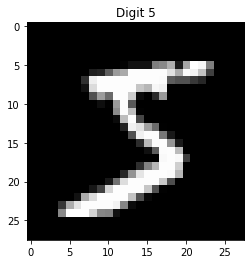

In [4]:
#################################################################################
#########                 precheck data from data loader                 ########
#################################################################################
train_X_y = enumerate(train_data_loader)
batch_idx, (train_X_torch, train_y_torch) = next(train_X_y)

# check the data
print(train_X_torch.shape)
print(train_y_torch.shape)

plt.imshow(train_X_torch[0,0,:,:], cmap='gray')
plt.title("Digit {}".format(train_y_torch[0]))

In [6]:
#################################################################################
#########                      build neural network                      ########
#################################################################################
class ShapesNet(nn.Module):
    def __init__(self, kernels=[4, 8], dropout = 0.2, classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(ShapesNet, self).__init__()
        self.kernels = kernels
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout()
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(kernels[0], kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout()
        )
        self.fc1 = nn.Linear(4 * 4 * kernels[-1], kernels[-1]) # pixel 64 / maxpooling 4 * 4 = 4
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return F.sigmoid(x)

In [7]:
#################################################################################
#########            configure hyper-parameters & prepare data           ########
#################################################################################
hyperparameters = dict(
    epoch = 10,
    classes = 1,
    kernels = [4, 8],
    batch_size = 100,
    learning_rate = 0.01,
    dropout = 0.1,
    dataset = 'Geographic shapes',
    architecture = 'CNN'
)

# initialize weights & biases service
wandb.init(config=hyperparameters, project='geometric-shapes', entity='dianna-ai')
config = wandb.config

# use pytorch data loader
train_X_torch = torch.from_numpy(train_X).type(torch.LongTensor)
train_y_torch = torch.from_numpy(train_y).type(torch.LongTensor)

test_X_torch = torch.from_numpy(test_X).type(torch.LongTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)

# reshape the input following the definition in pytorch (batch, channel, Height, Width)
train_X_torch = train_X_torch.view(-1,1,64,64).float()
test_X_torch = test_X_torch.view(-1,1,64,64).float()

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch,train_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch,test_y_torch)

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)


wandb: wandb version 0.10.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
#################################################################################
#########               create model and choose optimizer                ########
#################################################################################
model = MnistNet(config.kernels, config.dropout, config.classes)
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss() # same as BCELoss(torch.sigmoid(x),...), but more numerically stable
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)

wandb.watch(model)

Model details:
 ShapesNet(
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [9]:
#################################################################################
#########                   start the training process                   ########
#################################################################################
# calculate the time for the code execution
start_time = tt.time()
# switch model into train mode
model.train()

# function to calculate accuracy
def accuracy(y_pred, y_true):
    y_pred = torch.round(torch.sigmoid(y_pred))
    return (y_pred == y_true).sum() / len(y_pred)

for epoch in range(config.epoch):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).float()
        var_y_batch = torch.autograd.Variable(y_batch).float()
        optimizer.zero_grad()
        output = model(var_X_batch).squeeze(1)
        #print(output.detach().numpy())
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        #predicted = torch.max(output.data, 1)[1]
        predicted = torch.round(torch.sigmoid(output))
        correct += (predicted == var_y_batch).sum()
        #print(correct)
        wandb.log({'train_loss': loss.item(), 'train_acc': float(correct*100) / float(config.batch_size*(batch_idx+1))})
        if batch_idx % 4 == 0:
            print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                  epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.* batch_idx / len(train_loader),
                  loss.item(), float(correct*100) / float(config.batch_size*(batch_idx+1))))

# save the general checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, os.path.join(output_path,'shapesnet_training_checkpoint.pt'))

print ("--- %s minutes ---" % ((tt.time() - start_time)/60))

/home/yangliu/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch : 0 [0/8500 (0%)]	Loss: 0.692305	 Accuracy:52.000%
Epoch : 0 [400/8500 (5%)]	Loss: 0.702110	 Accuracy:50.800%
Epoch : 0 [800/8500 (9%)]	Loss: 0.699483	 Accuracy:51.556%
Epoch : 0 [1200/8500 (14%)]	Loss: 0.698200	 Accuracy:50.769%
Epoch : 0 [1600/8500 (19%)]	Loss: 0.708112	 Accuracy:50.647%
Epoch : 0 [2000/8500 (24%)]	Loss: 0.692727	 Accuracy:51.095%
Epoch : 0 [2400/8500 (28%)]	Loss: 0.694749	 Accuracy:50.360%
Epoch : 0 [2800/8500 (33%)]	Loss: 0.694419	 Accuracy:50.448%
Epoch : 0 [3200/8500 (38%)]	Loss: 0.693988	 Accuracy:50.727%
Epoch : 0 [3600/8500 (42%)]	Loss: 0.692960	 Accuracy:50.568%
Epoch : 0 [4000/8500 (47%)]	Loss: 0.695576	 Accuracy:50.439%
Epoch : 0 [4400/8500 (52%)]	Loss: 0.691038	 Accuracy:50.778%
Epoch : 0 [4800/8500 (56%)]	Loss: 

In [10]:
#################################################################################
#########                  start the evaluation process                  ########
#################################################################################
# switch model into evaluation mode
model.eval()
correct = 0
for test_imgs, test_labels in test_loader:
    #print(test_imgs.shape)
    test_imgs = torch.autograd.Variable(test_imgs).float()
    output = model(test_imgs)
    #predicted = torch.max(output,1)[1]
    predicted = torch.round(torch.sigmoid(output))
    correct += (predicted == test_labels).sum()
print("Test accuracy:{:.3f}% ".format(float(correct) / (len(test_loader)*config.batch_size)))


Test accuracy:51.251% 


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predictions: None
[0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1]
Ground Truth: None


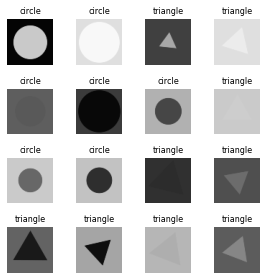

In [11]:
#################################################################################
#########                  check the evaluation results                  ########
#################################################################################
print("Predictions:", print(predicted[:20,0].detach().numpy()))
print("Ground Truth:", print(test_y[:20]))
evaluate_fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
axes = axes.flatten()

for i in range(16):
    a = axes[i]
    a.imshow(test_X[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(classes[test_y[i]], fontsize=8)
    a.axis('off')
    
evaluate_fig.tight_layout()